#### <b>Download the Original Datasets</b>

* <b>CelebA-HQ Dataset</b>: A dataset consisting of 30,000 "human face" images.
    * This dataset has approximately 3GB of data in size and is one of the most widely used face datasets worldwide.
* <b>CelebA-HQ Identity Dataset</b>: A dataset that provides information about <b>who the individuals (subjects) are</b> for each facial image file.
* <b>CelebA-HQ Attribute Dataset</b>: A dataset that provides attribute information for each facial image file.
    * This attribute information includes <b>gender</b>, <b>smiling</b>, and <b>age</b>, which we will be used for a multi-label task.

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb37jNPPA7hHl0fmktYqcV8B-qmPLx-ZKYQ1eFk4UPBV_A?download=1 -O CelebAMask-HQ.zip
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVRoUY8_txRFv56-KWvZrksBDWbD6adkjBxwwRN7qAC6bg?download=1 -O CelebA-HQ-identity.txt
!wget https://postechackr-my.sharepoint.com/:t:/g/personal/dongbinna_postech_ac_kr/EVrdIrPOkR1OlEWBVK8lE3AB9bFh741GnKBkNgPa8trNuA?download=1 -O CelebA-HQ-attribute.txt

In [ ]:
%%capture
!rm -rf ./CelebAMask-HQ
!unzip CelebAMask-HQ.zip

#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [1]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection
from sklearn.utils import shuffle

In [2]:
def train(model, dataloader):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step = 20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i + 1) % log_step == 0:
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running train loss: {current_loss:.4f}, running train accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'train loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()


def test(model, dataloader):
    start_time = time.time()
    print('[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    log_step=20

    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.size(0)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += torch.sum(preds == labels)

        if (i == 0) or ((i + 1) % log_step == 0):
            current_loss = running_loss / total
            current_acc = running_corrects.double() / total
            print(f'[Batch: {i + 1}] running test loss: {current_loss:.4f}, running test accuracy: {current_acc:.4f}')

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'test loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
    print("elapsed time:", time.time() - start_time)
    return epoch_loss, epoch_acc.item()

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []
    
    for inputs, labels in loader:
        targets = labels
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)
        losses = criterion(logits, targets).cpu().detach().numpy()
            
        #losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )


def cal_mia(model, unseen_dataloader):

    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}


@torch.no_grad()
def evaluation(model, data_loader):
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)  # Use the passed model argument here
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Use data_loader's dataset length for normalization
        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_loss = round(epoch_loss, 3)
        epoch_acc = running_corrects.item() / len(data_loader.dataset)

        return {'Loss': epoch_loss, 'Acc': epoch_acc}

#### <b>Load Identity Mapping</b>
* Check which person each file name is associated with.
* There are a total of 6,217 individuals (subjects) among the 30,000 files.

In [4]:
path = "./celeb_dataset/"

In [5]:
identities = {}

# (Image File Name, Subject Identity Information)
with open(path + 'CelebA-HQ-identity.txt') as f:
    lines = f.readlines()
    for line in lines:
        file_name, identity = line.strip().split()
        identities[file_name] = identity

print(f'There are {len(set(identities.values()))} identities.')
print(f'There are {len(identities.keys())} images.')

There are 6217 identities.
There are 30000 images.


#### <b>Choose Single Label to Use</b>
* "male": 21,
* "smiling": 32,
* "young": 40

In [6]:
label_map = {}

label_num = 32  # "male": 21, "smiling": 32, "young": 40

with open(path + 'CelebA-HQ-attribute.txt') as f:
    lines = f.readlines()
    for line in lines[2:]:
        splited = line.strip().split()
        file_name, label = splited[0], splited[label_num]
        label_map[file_name] = label

print(f'There are {len(set(label_map.values()))} classes.')
print(f'There are {len(label_map.keys())} images.')

There are 2 classes.
There are 30000 images.


#### <b>Split the Dataset</b>
* <b>Training dataset  $\mathcal{D}_{train}$</b>: 25,933 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: 2,065 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: 2,002 images.

In [7]:
source_root = path + 'CelebAMask-HQ/CelebA-HQ-img/'

train_index = 190
retrain_index = 1250
unseen_index = 4855

In [8]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < unseen_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [9]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < train_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [10]:
class ForgetDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity >= train_index and identity < retrain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [11]:
class RetrainDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index and identity >= retrain_index:
                label = int(label_map[file_name])
                if label == -1: label = 0
                self.labels.append((label, identity))
                self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [12]:
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None, train=False, test=False):
        self.image_path_list = glob.glob(os.path.join(source_root, "*"))
        # Shuffle the list of image paths
        self.image_path_list = shuffle(self.image_path_list, random_state=42)

        self.transform = transform

        self.image_paths = []
        self.labels = []
        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            label = int(label_map[file_name])
            if label == -1: label = 0
            self.labels.append((label, identity))
            self.image_paths.append(image_path)

        if train:
            self.labels = self.labels[:int(len(self.labels) * 0.8)]
            self.image_paths = self.image_paths[:int(len(self.image_paths) * 0.8)]
        elif test:
            self.labels = self.labels[int(len(self.labels) * 0.8):]
            self.image_paths = self.image_paths[int(len(self.image_paths) * 0.8):]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [13]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_set = TrainDataset(transform=train_transform)
test_set = TestDataset(transform=test_transform)
forget_set_train = ForgetDataset(transform=train_transform)
forget_set_test = ForgetDataset(transform=test_transform)
retrain_set_train = RetrainDataset(transform=train_transform)
retrain_set_test = RetrainDataset(transform=test_transform)
unseen_set_train = UnseenDataset(transform=unseen_transform, train=True, test=False)
unseen_set_test = UnseenDataset(transform=unseen_transform, train=False, test=True)

In [14]:
print('Train dataset size:', len(train_set))
print('Test dataset size:', len(test_set))
print('Forget dataset size:', len(forget_set_train))
print('Retrain dataset size:', len(retrain_set_train))
print('Train Unseen dataset size:', len(unseen_set_train))
print('Test Unseen dataset size:', len(unseen_set_test))

Train dataset size: 25933
Test dataset size: 2065
Forget dataset size: 10183
Retrain dataset size: 15750
Train Unseen dataset size: 1601
Test Unseen dataset size: 401



* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retrain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

In [15]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True)
forget_dataloader_train = torch.utils.data.DataLoader(forget_set_train, batch_size=64, shuffle=False, pin_memory=True)
forget_dataloader_test = torch.utils.data.DataLoader(forget_set_test, batch_size=64, shuffle=False, pin_memory=True)
retrain_dataloader_train = torch.utils.data.DataLoader(retrain_set_train, batch_size=64, shuffle=True, pin_memory=True)
retrain_dataloader_test = torch.utils.data.DataLoader(retrain_set_test, batch_size=64, shuffle=False,pin_memory=True)
unseen_dataloader_train = torch.utils.data.DataLoader(unseen_set_train, batch_size=64, shuffle=False, pin_memory=True)
unseen_dataloader_test = torch.utils.data.DataLoader(unseen_set_test, batch_size=64, shuffle=False, pin_memory=True)

In [16]:
train_image_paths = TrainDataset().image_paths
test_image_paths = TestDataset().image_paths
forget_image_paths = ForgetDataset().image_paths
retrain_image_paths = RetrainDataset().image_paths
unseen_image_paths = UnseenDataset(train=True).image_paths

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retrain_overlap = len(set(train_image_paths) & set(retrain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retrain_overlap = len(set(test_image_paths) & set(retrain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retrain_overlap = len(set(forget_image_paths) & set(retrain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retrain_unseen_overlap = len(set(retrain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retrain': train_retrain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retrain': test_retrain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retrain': forget_retrain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retrain_unseen': retrain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 10183,
 'train_retrain': 15750,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retrain': 0,
 'test_unseen': 0,
 'forget_retrain': 0,
 'forget_unseen': 0,
 'retrain_unseen': 0}

#### <b>Imgae Visualization</b>

In [17]:
if label_num == 21:
    label_convert = {0: "F", 1: "M"}
elif label_num == 32:
    label_convert = {0: "unsmiling", 1: "smiling"}
if label_num == 40:
    label_convert = {0: "old", 1: "young"}

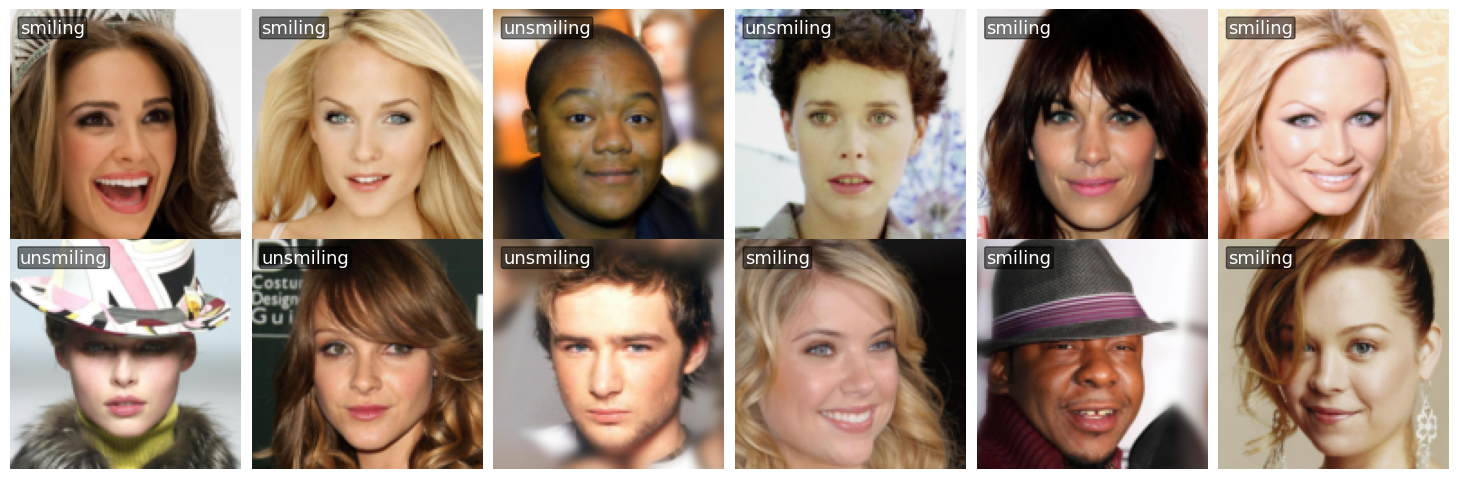

In [18]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_convert[label.item()] for label in labels[0:12]]

show_images(imgs[0:12], label_strs, nrow=6)

# Train original model

In [24]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
history = []
accuracy = []
num_original_epochs = 10
for epoch in range(num_original_epochs):
    train_loss, train_acc = train(model, train_dataloader)
    test_loss, test_acc = test(model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_original_epochs}_smile.pth')

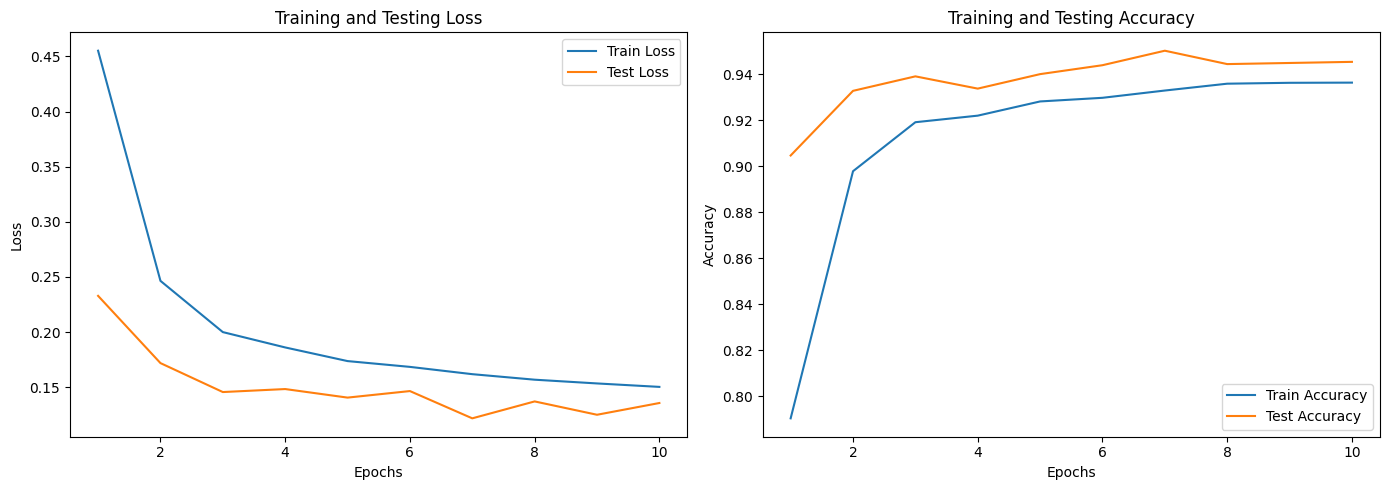

In [38]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Forgetting Functions

In [26]:
random.seed(42)

#### <b>Forgetting via DistillKL</b>

In [21]:
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
original_save_path = f'last_checkpoint_epoch_10_smile.pth'  # downloaded model
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 2)
original_model = original_model.cuda()
original_model.load_state_dict(torch.load(original_save_path))
criterion = nn.CrossEntropyLoss()

In [22]:
# Performance
log_step = 30
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader_test)
mia = cal_mia(original_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Loss': 0.136, 'Acc': 0.9452784503631961}
Unseen Acc: {'Loss': 0.289, 'Acc': 0.8927680798004988}
MIA: {'MIA': 0.5000000000000001, 'Forgeting Score': 1.1102230246251565e-16}
Final Score: 0.972639225181598


In [28]:
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}_gender.pth' # If you trian the original model from scratch.
original_save_path = f'last_checkpoint_epoch_10_smile.pth'  # downloaded model
forgot_model = models.resnet18(pretrained=False)
num_features = forgot_model.fc.in_features
forgot_model.fc = nn.Linear(num_features, 2)
forgot_model = forgot_model.cuda()
forgot_model.load_state_dict(torch.load(original_save_path))
criterion = nn.CrossEntropyLoss()

In [29]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [30]:
class NewUnseenDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None, unseen_set_train=None, forget_dataloader=None):
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.unseen_set_train = unseen_set_train
        self.image_path_list = self.unseen_set_train.image_paths
        self.forget_dataloader = forget_dataloader

        # Create a dict consist of image_path follow gender, smilling and young
        dict_labels_path = {}
        for image_path in self.image_path_list:
            image_path = image_path.replace("\\", "/")
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            label = int(label_map[file_name])
            if label == -1: label = 0

            # Use the (gender, smiling, young) tuple as the dictionary key
            key = label

            # Check if the key exists in the dictionary
            if key in dict_labels_path:
                dict_labels_path[key].append(image_path)
            else:
                dict_labels_path[key] = [image_path]

        # Create a new image_list
        new_image_list = []

        for i, (inputs_forget, label) in enumerate(self.forget_dataloader):
            # Convert labels to the same format as the outputs (float).
            labels_forget = label.cuda()
            
            for label in labels_forget:
                # Convert tensor label to tuple for dictionary key
                key = int(label)
                
                # Ensure the key exists in the dictionary
                if key in dict_labels_path and dict_labels_path[key]:
                    # Randomly select a sample from the list associated with this key
                    chosen_sample = random.choice(dict_labels_path[key])
                    new_image_list.append(chosen_sample)
                else:
                    # Handle the case where the key does not exist or has no associated samples
                    print(f"No samples found for key {key}")

        self.image_path_list = new_image_list

        for image_path in self.image_path_list:
            file_name = image_path.split('/')[-1]
            identity = int(identities[file_name])
            if identity < unseen_index:
                continue
            label = int(label_map[file_name])
            if label == -1: label = 0
         
            self.labels.append((label, identity))
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label[0])

        return image, label

In [33]:
class Forgetting_Function:
    def __init__(self, original_model, forgot_model, unseen_set_train, forget_dataloader):
        self.original_model = original_model
        self.forgot_model = forgot_model
        self.forget_dataloader = forget_dataloader
        self.unseen_set_train = unseen_set_train
        self.criterion_div = DistillKL(4.0)
        self.optimizer = optim.SGD(self.forgot_model.parameters(), lr=0.001)
        self.criterion = torch.nn.CrossEntropyLoss()

    def train_epoch(self):
        set_seed(42)
        self.forgot_model.train()
        self.original_model.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_div, total_accuracy_forget = 0, 0
        
        # Process new unseen_dataloader
        new_unseen_dataset = NewUnseenDataset(unseen_transform, unseen_set_train=self.unseen_set_train, forget_dataloader=self.forget_dataloader)
        new_unseen_dataloader = DataLoader(new_unseen_dataset, batch_size=64, shuffle=False)
        
        #for (inputs_unseen, labels_unseen), (inputs_forget, labels_forget) in zip(new_unseen_dataloader, self.forget_dataloader):
        #    for i in range(len(labels_unseen)):
        #        if labels_unseen[i] != labels_forget[i]:
        #            print(labels_unseen[i], labels_forget[i])
        
        # Training with unseen data.
        flag = 1

        for (inputs_unseen, labels_unseen), (inputs_forget, labels_forget) in zip(new_unseen_dataloader, self.forget_dataloader):
            inputs_unseen, labels_unseen = inputs_unseen.cuda(), labels_unseen.cuda()
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            outputs_forget = self.forgot_model(inputs_forget)

            with torch.no_grad():
                outputs_unseen = self.original_model(inputs_unseen)

            # Loss computation
            loss_div = flag * self.criterion_div(outputs_forget, outputs_unseen)

            # Update total loss and accuracy for unseen data.
            total_loss_div += loss_div.item()
            total_accuracy_forget += compute_accuracy(outputs_forget, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div.backward()
            self.optimizer.step()
            
            if flag == 1:
                flag = -1
            else:
                flag = 1

        # Print average loss and accuracy for the entire epoch
        avg_loss_div = total_loss_div / len(self.forget_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        mia = cal_mia(self.forgot_model.cuda(), unseen_dataloader_train)

        print(f'Epoch unseen: Avg Loss: {avg_loss_div:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}, Forgeting Score: {mia["Forgeting Score"]}')

In [34]:
set_seed(42)

# Initialize and train
forgetting_trainer = Forgetting_Function(original_model, forgot_model, unseen_set_train, forget_dataloader_train)

num_epochs = 1
for epoch in range(num_epochs):
    forgetting_trainer.train_epoch()
    print(f"Epoch {epoch+1} completed.")

Epoch unseen: Avg Loss: 0.0016, Avg Accuracy: 94.86, Forgeting Score: 0.012149532710280408
Epoch 1 completed.


In [35]:
# Performance
log_step = 30
test_acc = evaluation(forgot_model, test_dataloader)
unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
mia = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Test Acc: {'Loss': 0.124, 'Acc': 0.9501210653753026}
Unseen Acc: {'Loss': 0.293, 'Acc': 0.9077306733167082}
MIA: {'MIA': 0.49753086419753084, 'Forgeting Score': 0.002469135802469158}
Final Score: 0.9725913968851821


# Improve accuracy

In [27]:
#num_epochs = 1
#learning_rate = 0.01
#log_step = 30
#
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(forgot_model.parameters(), lr=learning_rate, momentum=0.9)
#
#for epoch in range(num_epochs):
#    train_loss, train_acc = train(forgot_model, retrain_dataloader_train)
#    test_loss, test_acc = test(forgot_model, test_dataloader)

In [ ]:
# Performance
#log_step = 30
#test_acc = evaluation(forgot_model, test_dataloader)
#unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
#mia = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
#print(f'Test Acc: {test_acc}')
#print(f'Unseen Acc: {unseen_acc}')
#print(f'MIA: {mia}')
#print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

# Retrained Model

In [36]:
learning_rate = 0.01
log_step = 30

retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 2)
retrained_model = retrained_model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

In [37]:
learning_rate = 0.01
best_test_acc = 0
best_epoch = 0

history = []
accuracy = []
num_original_epochs = 10
for epoch in range(num_original_epochs):
    train_loss, train_acc = train(retrained_model, retrain_dataloader_train)
    test_loss, test_acc = test(retrained_model, test_dataloader)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.7637, running train accuracy: 0.5047
[Batch: 40] running train loss: 0.7450, running train accuracy: 0.5371
[Batch: 60] running train loss: 0.7329, running train accuracy: 0.5479
[Batch: 80] running train loss: 0.7252, running train accuracy: 0.5633
[Batch: 100] running train loss: 0.6835, running train accuracy: 0.6011
[Batch: 120] running train loss: 0.6582, running train accuracy: 0.6267
[Batch: 140] running train loss: 0.6267, running train accuracy: 0.6512
[Batch: 160] running train loss: 0.5923, running train accuracy: 0.6749
[Batch: 180] running train loss: 0.5746, running train accuracy: 0.6915
[Batch: 200] running train loss: 0.5535, running train accuracy: 0.7063
[Batch: 220] running train loss: 0.5357, running train accuracy: 0.7185
[Batch: 240] running train loss: 0.5170, running train accuracy: 0.7312
train loss: 0.5115, accuracy: 0.7346
elapsed time: 483.16057205200195
[Test]
[Batch: 1] running test loss: 0.3334, run

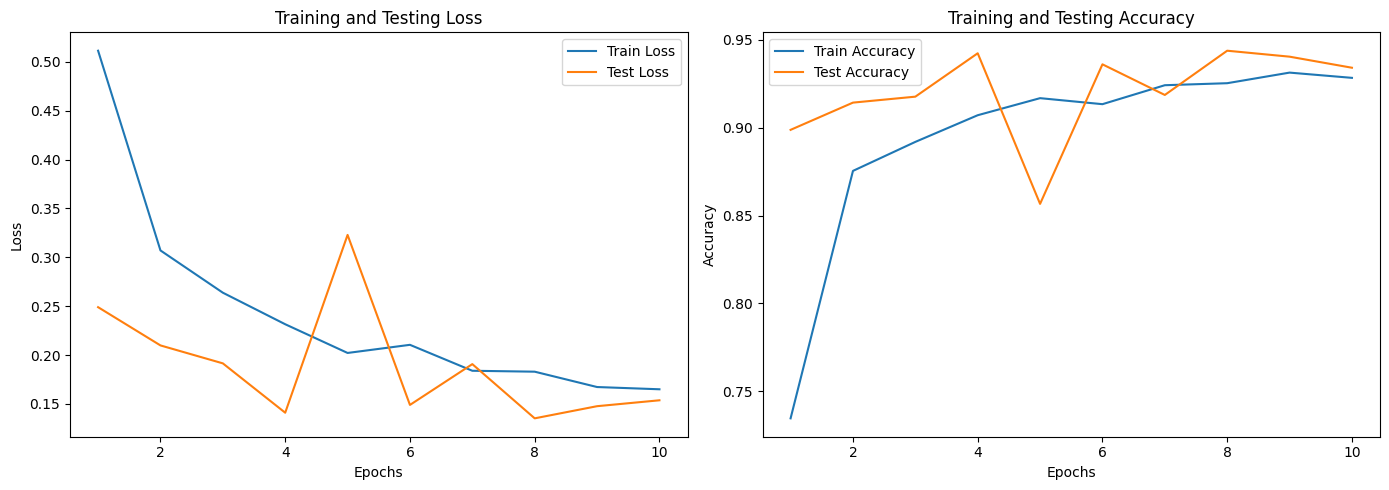

In [38]:
import matplotlib.pyplot as plt

train_losses, test_losses = zip(*history)
train_accuracies, test_accuracies = zip(*accuracy)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader_test)
mia = cal_mia(retrained_model.cuda(), unseen_dataloader_test)
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


Test Acc: {'Loss': 0.154, 'Acc': 0.9341404358353511}
Unseen Acc: {'Loss': 0.404, 'Acc': 0.8603491271820449}
MIA: {'MIA': 0.5395061728395061, 'Forgeting Score': 0.03950617283950608}
Final Score: 0.9275640450781695
